In [1]:
import numpy as np
import pandas as pd

import healpy as hp
from tqdm import tqdm, tqdm_notebook
import scipy as sp
from scipy.special import erf

import sys
from my_units import * 

from angular_fn import *
from template_fn import *
from cov_matrix_fn import *

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

HomeDir = './'
DataDir = HomeDir #+ 'code/'
### Set this to the directory where you store your data files (see below how to download them)
ListDir = HomeDir+'lists/hist_stats/'
FigDir = HomeDir+'figures/'

# Read in Files

In [2]:
stars_df = pd.read_csv(DataDir+'pairs_background_ruwe_w_st.csv', usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'pmra_eff_error', 'pmdec_eff_error', 'pmra_pmdec_eff_corr', 'parallax', 'parallax_error', 'pmra_sub', 'pmdec_sub', 'phot_g_mean_mag', 'l', 'b', 'ruwe'])
print('Backgrounds read in.')

df_fore = pd.read_csv(DataDir+'pairs_foreground_ruwe_w_st.csv', usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'l', 'b', 'ruwe'])
print('Foregrounds read in.')

back_dist = pd.read_csv('bg_dist.csv', header=None)
fore_dist = pd.read_csv('fg_dist.csv', header=None)

Backgrounds read in.
Foregrounds read in.


In [3]:
bg_sub_ind = np.load('bg_sub_ind.npy')

In [4]:
df_fore.shape

(61138843, 13)

In [5]:
bg_sub_ind.shape

(9012073,)

In [6]:
stars_df = stars_df.loc[bg_sub_ind]
df_fore = df_fore.loc[bg_sub_ind]
back_dist = back_dist.loc[bg_sub_ind]
fore_dist = fore_dist.loc[bg_sub_ind]

In [7]:
back_dist_med = back_dist[1].to_numpy()
back_dist_lo = back_dist[2].to_numpy()
back_dist_hi = back_dist[3].to_numpy()

fore_dist_med = fore_dist[1].to_numpy()
fore_dist_lo = fore_dist[2].to_numpy()
fore_dist_hi = fore_dist[3].to_numpy()

stars_df['dist'] = back_dist_med
stars_df['dist_error'] = ((back_dist_med - back_dist_lo) + (back_dist_hi - back_dist_med)) / 2

In [8]:
df_fore.shape

(9012073, 13)

# Import bin definitions

In [9]:
from bin_defs import *

hp.nside2npix(hp.order2nside(n)), len(bins_dist), len(bins_G), len(bins_bil)

(3072, 7, 7, 12)

In [10]:
### Get the pixel bin index for the background stars
q_pix = np.floor(stars_df['source_id'].to_numpy() / fac_source_id).astype(int)
bins_pix = np.arange(np.min(np.unique(q_pix)), np.max(np.unique(q_pix))+2,1) # should be +2 to include sources in the last bin
q_binpix = np.digitize(q_pix, bins_pix)-1  # need to access the histogram matrix elements

# assign to G bins
bg_G = stars_df['phot_g_mean_mag'].to_numpy()
q_bin_G = np.digitize(bg_G, bins_G) - 1  

# assign to radial bins
## necessary columns
fg_ra = df_fore['ra'].to_numpy()
fg_dec = df_fore['dec'].to_numpy()
bg_ra = stars_df['ra'].to_numpy()
bg_dec = stars_df['dec'].to_numpy()
## bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2

## bin definitions
q_bil = np.sqrt(l_bilnormsq)/arcsec
q_bin_bil = np.digitize(q_bil, bins_bil) - 1

In [11]:
# probabilistic assignment to distance bins
bg_dist = stars_df['dist'].to_numpy()
# bg error is average of posteriors
bg_dist_error = stars_df['dist_error'].to_numpy()

prob_dist = np.nan * np.ones((len(stars_df),len(bins_dist)-1))
for i in tqdm(range(len(bins_dist)-1)):
    x1_list = (bins_dist[i]-bg_dist)/bg_dist_error/np.sqrt(2)
    x2_list = (bins_dist[i+1]-bg_dist)/bg_dist_error/np.sqrt(2)
    prob_dist[:,i] = 0.5*(erf(x2_list)-erf(x1_list))

100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


In [12]:
### read in total bg pm histogram
hist_pm_total = pd.read_csv('bg_pm_hist.csv')

In [13]:
hist_pm_total.shape

(1216512, 11)

In [14]:
np.sum(hist_pm_total[hist_pm_total['number'] < 30]['number'])

401995.8697610075

In [15]:
hist_pm_total.shape

(1216512, 11)

In [16]:
### Indices of the stars in the flattened stats histogram
stars_i = q_bin_bil + q_bin_G * (len(bins_bil)-1) + q_binpix * (len(bins_G)-1) * (len(bins_bil)-1) #q_binG + q_bin_bil*(len(bins_G)-1) 
stars_i

array([    51,     52,     39, ..., 202739, 202736, 202735])

In [17]:
### Get proper motion stats (need to loop over dist bins)

w_pm_st = np.zeros((len(stars_df), 6)); w_pm_sum = np.zeros((len(stars_df), 6))
tot_pm = 0

for i in tqdm(range(len(bins_dist)-1)):
    hist_pm = hist_pm_total[np.abs(hist_pm_total['dist_bin']-bins_dist[i])<1e-5] # select dist bin from total histogram
    print(hist_pm.shape)
    tot_pm += hist_pm.shape[0]
    hist_pm.sort_values(['pix', 'G_bin','bil_bin'],inplace=True) # sort histogram
    stars_stat = hist_pm.iloc[stars_i] # get stats for the stars in the list
    st = stars_stat[['mean_pmra', 'mean_pmdec', 'var_pmra', 'var_pmdec', 'var_pmradec', 'number']].to_numpy()
    
    no_nan_loc_to_1 = (~np.isnan(st)).astype(int) # convert to 1 non-nan elements and to 0 nan elements (to sum over weights)
    w_pm_sum += (no_nan_loc_to_1.T * prob_dist[:, i]).T        
    st[np.isnan(st)] = 0 # replace nan values with zero
    w_pm_st += (st.T * prob_dist[:, i]).T # weighted statistic for i-th dist bin   
    
w_pm_st = w_pm_st/(w_pm_sum + 1E-20)

  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_2666827/2451045402.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_pm.sort_values(['pix', 'G_bin','bil_bin'],inplace=True) # sort histogram


(202752, 11)


 17%|█▋        | 1/6 [00:02<00:11,  2.25s/it]/tmp/ipykernel_2666827/2451045402.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_pm.sort_values(['pix', 'G_bin','bil_bin'],inplace=True) # sort histogram


(202752, 11)


 33%|███▎      | 2/6 [00:04<00:08,  2.17s/it]/tmp/ipykernel_2666827/2451045402.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_pm.sort_values(['pix', 'G_bin','bil_bin'],inplace=True) # sort histogram


(202752, 11)


 50%|█████     | 3/6 [00:06<00:06,  2.22s/it]/tmp/ipykernel_2666827/2451045402.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_pm.sort_values(['pix', 'G_bin','bil_bin'],inplace=True) # sort histogram


(202752, 11)


 67%|██████▋   | 4/6 [00:08<00:04,  2.13s/it]/tmp/ipykernel_2666827/2451045402.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_pm.sort_values(['pix', 'G_bin','bil_bin'],inplace=True) # sort histogram


(202752, 11)


 83%|████████▎ | 5/6 [00:10<00:02,  2.11s/it]/tmp/ipykernel_2666827/2451045402.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_pm.sort_values(['pix', 'G_bin','bil_bin'],inplace=True) # sort histogram


(202752, 11)


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


In [18]:
### create stats df
stats_df = pd.DataFrame(w_pm_st, columns=['mean_pmra', 'mean_pmdec', 'var_pmra', 'var_pmdec', 'var_pmradec','number'])
### For some stars stats info is not avaliable. Replace nan values with zero.
stats_df.replace(np.nan, 0, inplace=True)

In [19]:
stats_df.shape

(9012073, 6)

In [20]:
stats_df[stats_df['number']<30]

,mean_pmra,mean_pmdec,var_pmra,var_pmdec,var_pmradec,number
0,0.0,0.0,0.0,0.0,0.0,0.294649
1,0.0,0.0,0.0,0.0,0.0,0.319641
2,0.0,0.0,0.0,0.0,0.0,0.446987
3,0.0,0.0,0.0,0.0,0.0,0.467716
4,0.0,0.0,0.0,0.0,0.0,0.395856
...,...,...,...,...,...,...
9012068,0.0,0.0,0.0,0.0,0.0,0.408242
9012069,0.0,0.0,0.0,0.0,0.0,0.433132
9012070,0.0,0.0,0.0,0.0,0.0,0.355885
9012071,0.0,0.0,0.0,0.0,0.0,0.392064


In [21]:
df_fore = df_fore[stats_df['number'].to_numpy() >= 30]
stars_df = stars_df[stats_df['number'].to_numpy() >= 30]
stats_df = stats_df[stats_df['number'].to_numpy() >= 30]

In [22]:
### Add columns to the stars data fram with the subtracted quantities and the effective errors

### subtract the already-subtracted motions 
stars_df['pmra_sub_new'] = stars_df['pmra'] - stats_df['mean_pmra'].to_numpy()
stars_df['pmdec_sub_new'] = stars_df['pmdec'] - stats_df['mean_pmdec'].to_numpy()


stars_df['pmra_eff_error_new'] = np.sqrt(stats_df['var_pmra'].to_numpy())
stars_df['pmdec_eff_error_new'] = np.sqrt(stats_df['var_pmdec'].to_numpy())

In [23]:
### defunct
### For stars that do not have stats info, use the instrumental error instead of the effective error
zero_ind_pm = (stats_df['mean_pmra'].to_numpy()==0)

stars_df['pmra_eff_error_new'].iloc[zero_ind_pm] = stars_df['pmra_error'].iloc[zero_ind_pm]
stars_df['pmdec_eff_error_new'].iloc[zero_ind_pm] = stars_df['pmdec_error'].iloc[zero_ind_pm]


/tmp/ipykernel_2666827/3419033105.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_df['pmra_eff_error_new'].iloc[zero_ind_pm] = stars_df['pmra_error'].iloc[zero_ind_pm]
/tmp/ipykernel_2666827/3419033105.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_df['pmdec_eff_error_new'].iloc[zero_ind_pm] = stars_df['pmdec_error'].iloc[zero_ind_pm]


In [24]:
### Add column for the pmra and pmdec correlation
stars_df['pmra_pmdec_eff_corr_new'] = stats_df['var_pmradec'].to_numpy()/(stars_df['pmra_eff_error'].to_numpy()*stars_df['pmdec_eff_error'].to_numpy())
stars_df['pmra_pmdec_eff_corr_new'].iloc[zero_ind_pm] = stars_df['pmra_pmdec_corr'].iloc[zero_ind_pm]

/tmp/ipykernel_2666827/3158718153.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_df['pmra_pmdec_eff_corr_new'].iloc[zero_ind_pm] = stars_df['pmra_pmdec_corr'].iloc[zero_ind_pm]


Text(0.5, 0.98, 'New Subtraction')

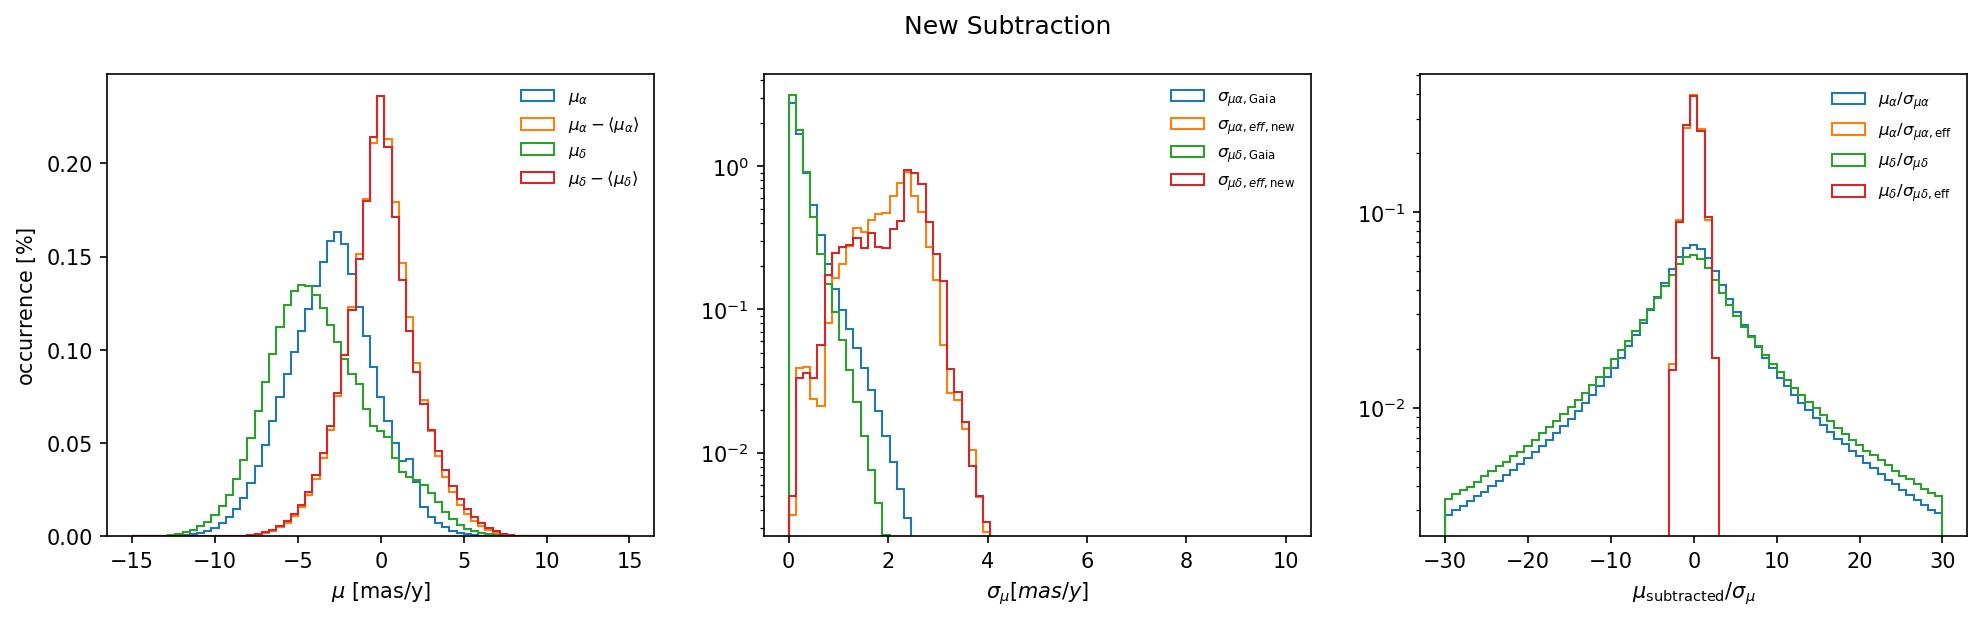

In [25]:
fig,ax = plt.subplots(1,3,figsize=(16,4), dpi = 150)

xmax, nbins = 15, 70
ax[0].hist(stars_df['pmra'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmra_sub_new'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmdec'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmdec_sub_new'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].legend([r'$\mu_\alpha$', r'$\mu_\alpha - \langle \mu_\alpha \rangle$', '$\mu_\delta$', r'$\mu_\delta - \langle \mu_\delta \rangle$'], loc='upper right', fontsize = 8, frameon=False);
ax[0].set_xlabel(r'$\mu$ [mas/y]'); ax[0].set_ylabel(r'occurrence [$\%$]');
#ax.set_title(r'Velocity template for '+str(len(tau_list[map_count>min_count]))+' subsets', fontsize = 16);

xmax, nbins = 10, 70
#ax[1].hist(stars_df['pmra_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmra_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
#ax[1].hist(stars_df['pmdec_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmra_eff_error_new'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmdec_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmdec_eff_error_new'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');

ax[1].legend([r'$\sigma_{\mu\alpha, \mathrm{Gaia}}$', r'$\sigma_{\mu\alpha, eff, \mathrm{new}}$', r'$\sigma_{\mu\delta, \mathrm{Gaia}}$', r'$\sigma_{\mu\delta, eff, \mathrm{new}}$'], 
             loc='upper right', fontsize = 8, frameon=False);
ax[1].set_xlabel(r'$\sigma_\mu [mas/y]$'); #ax[1].set_ylabel(r'occurrence [$\%$]');

xmax, nbins = 30, 70
ax[2].hist(stars_df['pmra_sub_new']/stars_df['pmra_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmra_sub_new']/stars_df['pmra_eff_error_new'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmdec_sub_new']/stars_df['pmdec_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmdec_sub_new']/stars_df['pmdec_eff_error_new'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].legend([r'$\mu_{\alpha}/\sigma_{\mu\alpha}$', r'$\mu_{\alpha}/\sigma_{\mu\alpha, \mathrm{eff}}$', 
              r'$\mu_{\delta}/\sigma_{\mu\delta}$', r'$\mu_{\delta}/\sigma_{\mu\delta, \mathrm{eff}}$'], loc='upper right', fontsize = 8, frameon=False);
ax[2].set_xlabel(r'$\mu_\mathrm{subtracted}/\sigma_\mu$'); #ax[2].set_ylabel(r'occurrence [$\%$]');

#plt.tight_layout()
plt.suptitle('New Subtraction')
#fig.savefig(FigDir+'pm_stats.pdf')

Text(0.5, 0.98, 'Old subtraction')

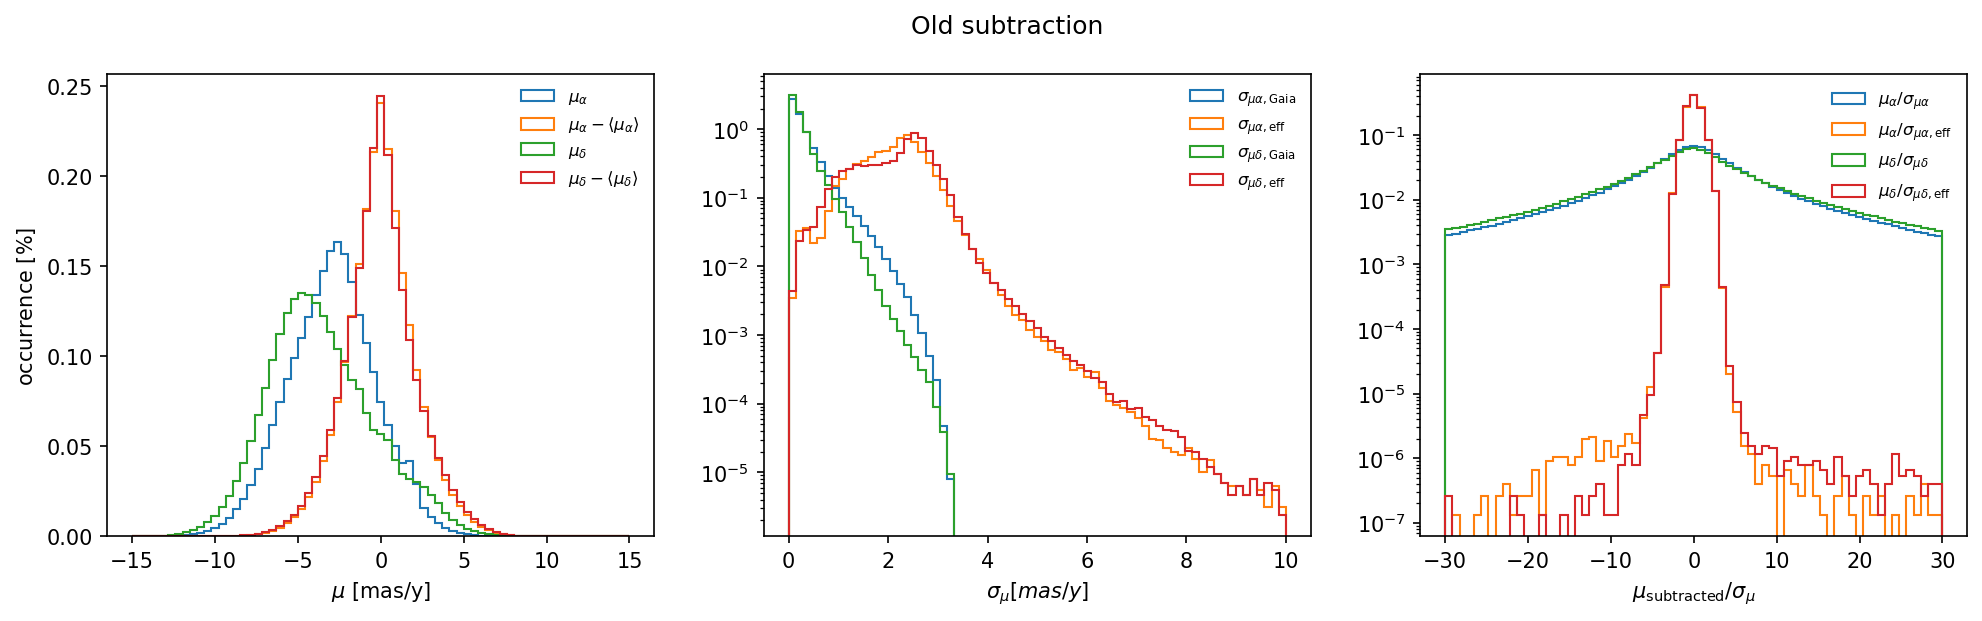

In [26]:
fig,ax = plt.subplots(1,3,figsize=(16,4), dpi = 150)

xmax, nbins = 15, 70
ax[0].hist(stars_df['pmra'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmra_sub'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmdec'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmdec_sub'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].legend([r'$\mu_\alpha$', r'$\mu_\alpha - \langle \mu_\alpha \rangle$', '$\mu_\delta$', r'$\mu_\delta - \langle \mu_\delta \rangle$'], loc='upper right', fontsize = 8, frameon=False);
ax[0].set_xlabel(r'$\mu$ [mas/y]'); ax[0].set_ylabel(r'occurrence [$\%$]');
#ax.set_title(r'Velocity template for '+str(len(tau_list[map_count>min_count]))+' subsets', fontsize = 16);

xmax, nbins = 10,70
ax[1].hist(stars_df['pmra_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmra_eff_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmdec_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmdec_eff_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].legend([r'$\sigma_{\mu\alpha, \mathrm{Gaia}}$', r'$\sigma_{\mu\alpha, \mathrm{eff}}$', r'$\sigma_{\mu\delta, \mathrm{Gaia}}$', r'$\sigma_{\mu\delta, \mathrm{eff}}$'], 
             loc='upper right', fontsize = 8, frameon=False);
ax[1].set_xlabel(r'$\sigma_\mu [mas/y]$'); #ax[1].set_ylabel(r'occurrence [$\%$]');

xmax, nbins = 30, 70
ax[2].hist(stars_df['pmra_sub']/stars_df['pmra_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmra_sub']/stars_df['pmra_eff_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmdec_sub']/stars_df['pmdec_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmdec_sub']/stars_df['pmdec_eff_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].legend([r'$\mu_{\alpha}/\sigma_{\mu\alpha}$', r'$\mu_{\alpha}/\sigma_{\mu\alpha, \mathrm{eff}}$', 
              r'$\mu_{\delta}/\sigma_{\mu\delta}$', r'$\mu_{\delta}/\sigma_{\mu\delta, \mathrm{eff}}$'], loc='upper right', fontsize = 8, frameon=False);
ax[2].set_xlabel(r'$\mu_\mathrm{subtracted}/\sigma_\mu$'); #ax[2].set_ylabel(r'occurrence [$\%$]');

#plt.tight_layout()
fig.suptitle('Old subtraction')
#fig.savefig(FigDir+'pm_stats.pdf')

## Plotting the variances

In [27]:
# assign to radial bins
## necessary columns
fg_ra = df_fore['ra'].to_numpy()
fg_dec = df_fore['dec'].to_numpy()
bg_ra = stars_df['ra'].to_numpy()
bg_dec = stars_df['dec'].to_numpy()
## bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
## bin definitions
q_bil = np.sqrt(l_bilnormsq)/arcsec
q_bin_bil = np.digitize(q_bil, bins_bil) - 1

In [28]:
direction = stars_df['pmra_sub_new']

var_ra = np.zeros(len(bins_bil))

for i_b in tqdm(range(len(bins_bil))):
    direction_i_b = direction[q_bin_bil == i_b]
    var_ra[i_b] = np.var(direction_i_b) 

100%|██████████| 12/12 [00:00<00:00, 16.77it/s]


In [29]:
direction = stars_df['pmdec_sub_new']

var_dec = np.zeros(len(bins_bil))

for i_b in tqdm(range(len(bins_bil))):
    direction_i_b = direction[q_bin_bil == i_b]
    var_dec[i_b] = np.var(direction_i_b) 

100%|██████████| 12/12 [00:00<00:00, 17.25it/s]


In [30]:
eff_pmra = stars_df['pmra_eff_error_new']
eff_pmdec = stars_df['pmdec_eff_error_new']

var = np.zeros(len(bins_bil))

for i_b in tqdm(range(len(bins_bil))):
    eff_pmra_i_b = eff_pmra[q_bin_bil == i_b]
    eff_pmdec_i_b = eff_pmdec[q_bin_bil == i_b]
    var[i_b] = np.mean(eff_pmra_i_b**2 + eff_pmdec_i_b**2)

100%|██████████| 12/12 [00:01<00:00,  9.56it/s]


In [31]:
eff_pmra = stars_df['pmra_eff_error']
eff_pmdec = stars_df['pmdec_eff_error']

var_old = np.zeros(len(bins_bil))

for i_b in tqdm(range(len(bins_bil))):
    eff_pmra_i_b = eff_pmra[q_bin_bil == i_b]
    eff_pmdec_i_b = eff_pmdec[q_bin_bil == i_b]
    var_old[i_b] = np.mean(eff_pmra_i_b**2 + eff_pmdec_i_b**2)

100%|██████████| 12/12 [00:01<00:00,  9.59it/s]


In [32]:
var

array([        nan, 15.41906832, 13.29750438, 10.26411139,  9.5200891 ,
        9.54142066,  9.47751182,  9.43148313,  9.34536989,  9.29984638,
               nan,         nan])

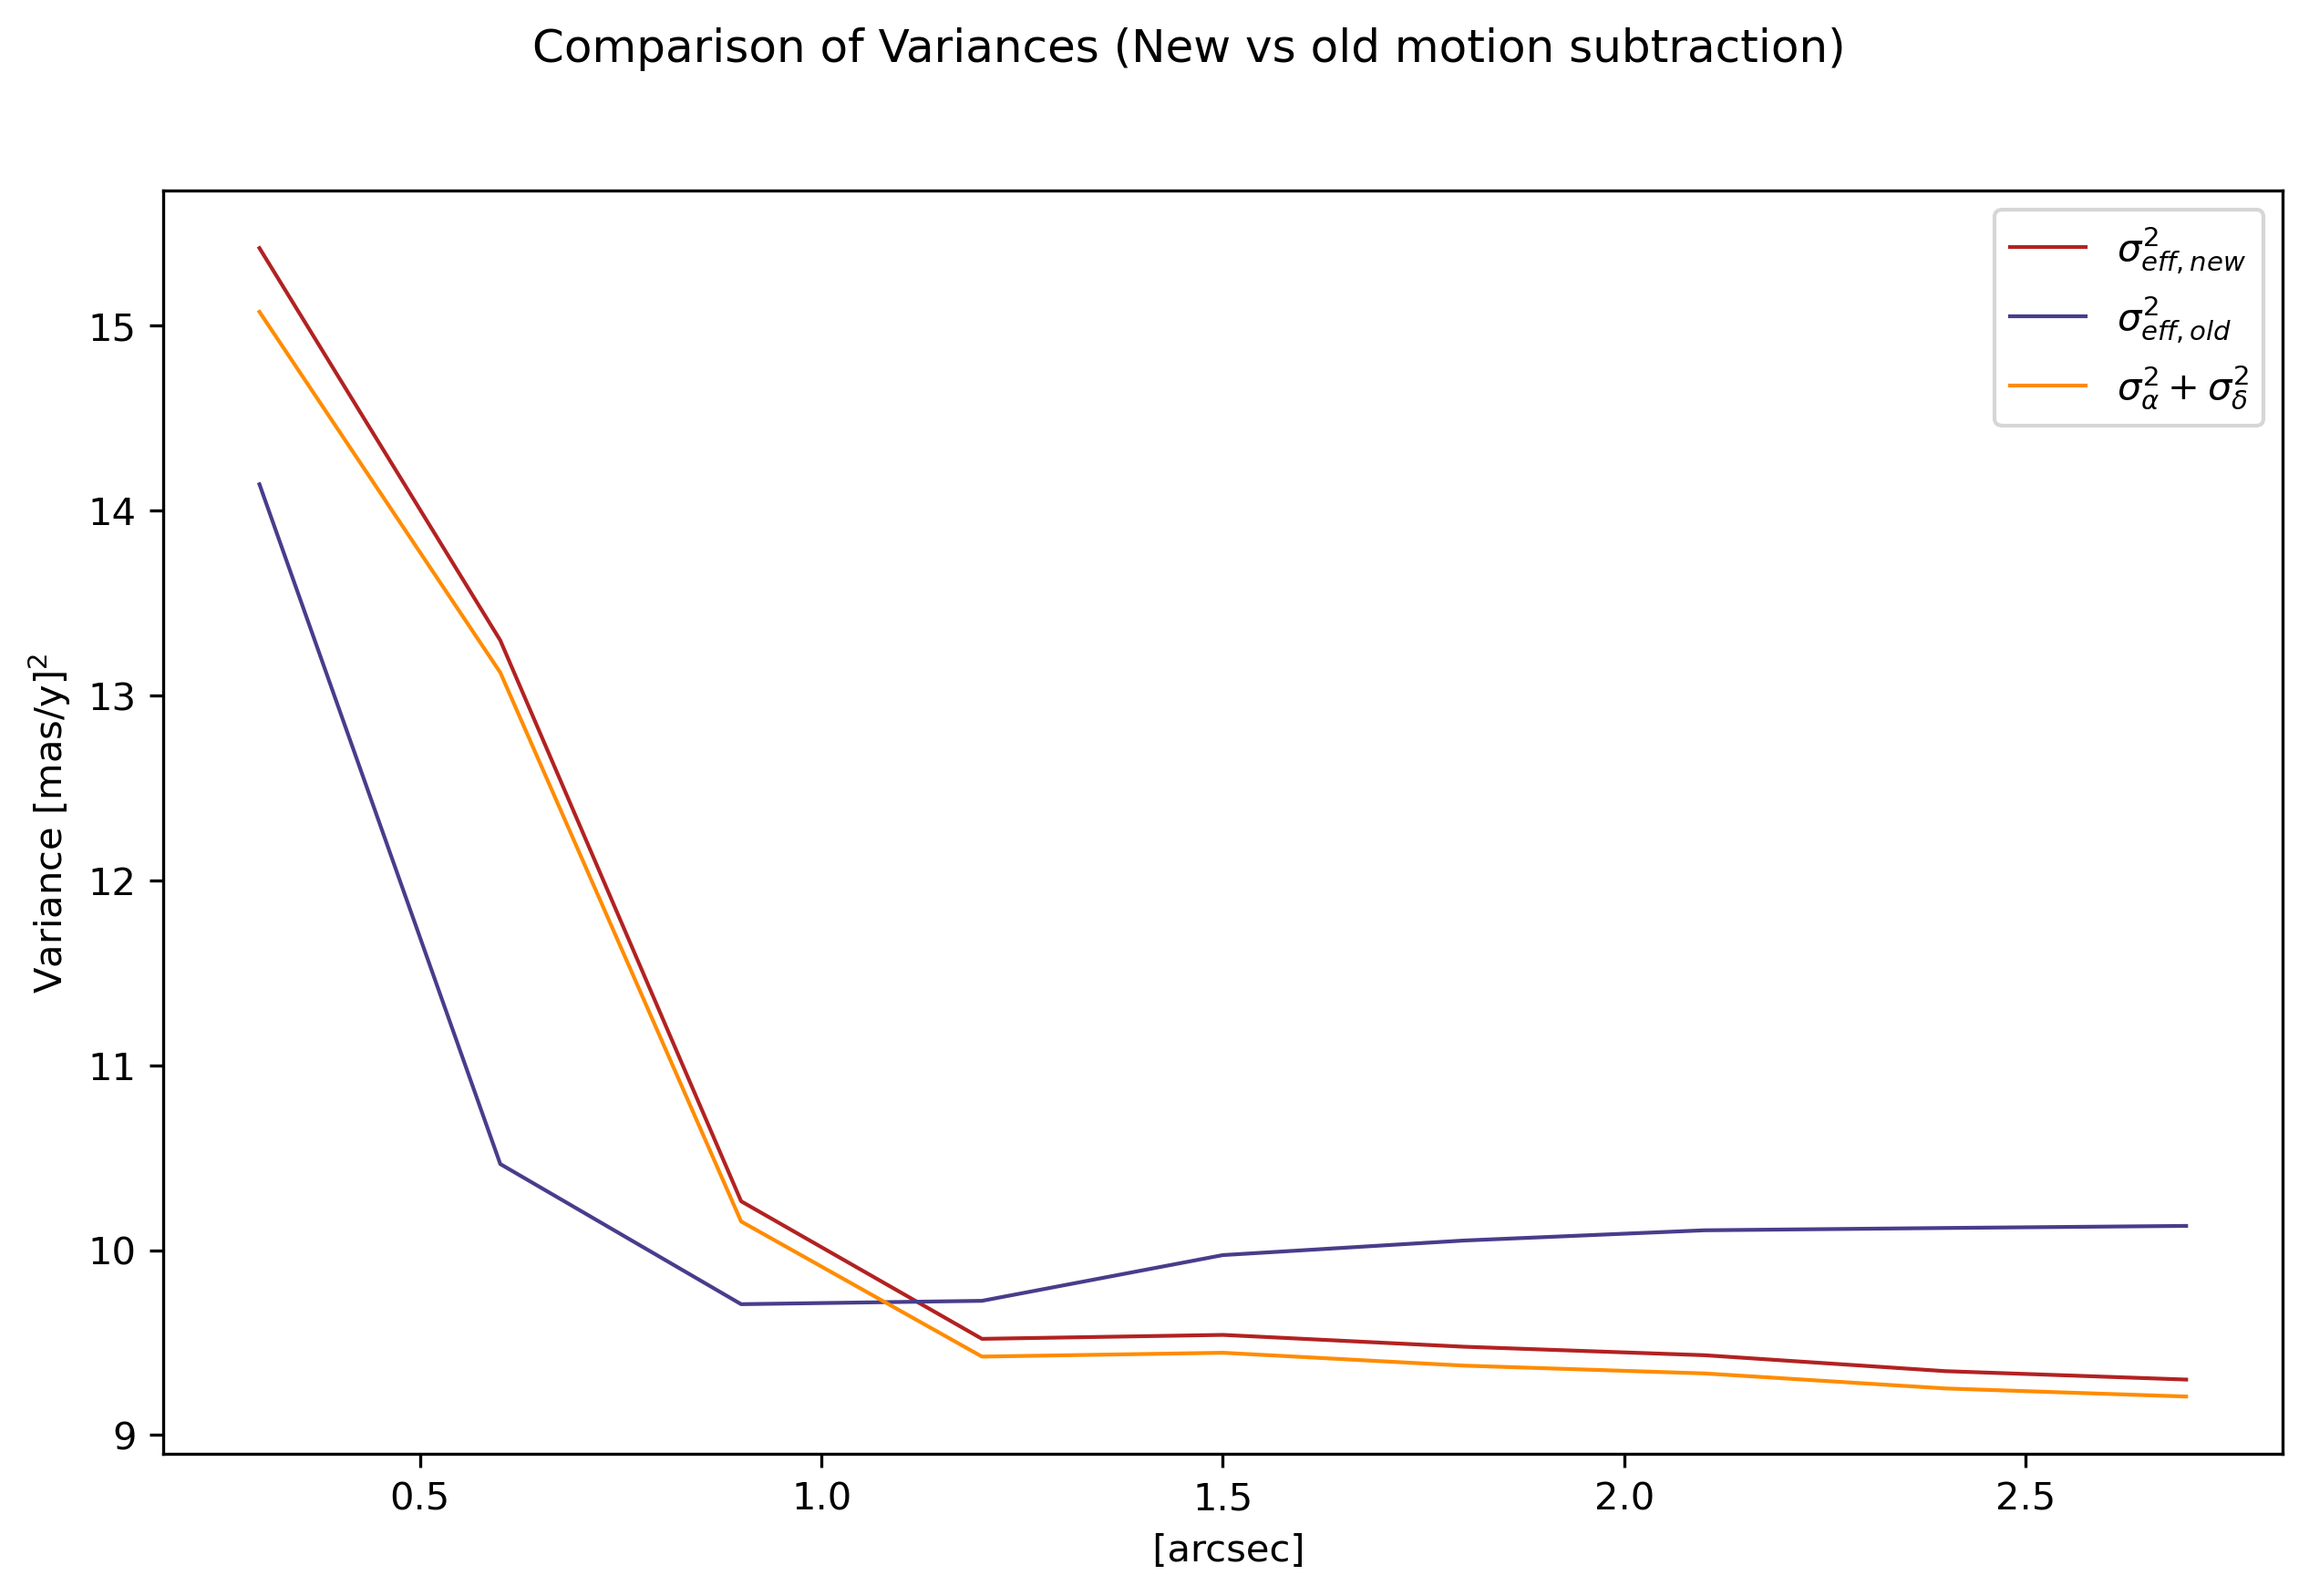

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,6),dpi=300)
ax.plot(bins_bil, var, label = r'$\sigma_{eff, new}^2$', lw = 1, color = 'firebrick')
ax.plot(bins_bil, var_old, label = r'$\sigma_{eff, old}^2$', lw = 1, color = 'darkslateblue')
ax.plot(bins_bil, var_ra + var_dec , label = r'$\sigma_{\alpha}^2 + \sigma_{\delta}^2$', lw = 1, color = 'darkorange')

ax.set_ylabel(r'Variance [mas/y]$^2$')
ax.set_xlabel(r' [arcsec]')
fig.suptitle('Comparison of Variances (New vs old motion subtraction)')
ax.legend()

In [34]:
stars_df.columns

Index(['source_id', 'ra', 'dec', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'pmra_pmdec_corr', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'l',
       'b', 'ruwe', 'pmra_sub', 'pmdec_sub', 'pmra_eff_error',
       'pmdec_eff_error', 'pmra_pmdec_eff_corr', 'dist', 'dist_error',
       'pmra_sub_new', 'pmdec_sub_new', 'pmra_eff_error_new',
       'pmdec_eff_error_new', 'pmra_pmdec_eff_corr_new'],
      dtype='object')

In [35]:
stars_df.to_csv('new_sub.csv', columns=['pmra_sub_new',
       'pmdec_sub_new', 'pmra_eff_error_new', 'pmdec_eff_error_new',
       'pmra_pmdec_eff_corr_new'])

In [36]:
stars_df.shape

(8763142, 26)

In [37]:
stars_df

,source_id,ra,dec,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,parallax,parallax_error,...,pmra_eff_error,pmdec_eff_error,pmra_pmdec_eff_corr,dist,dist_error,pmra_sub_new,pmdec_sub_new,pmra_eff_error_new,pmdec_eff_error_new,pmra_pmdec_eff_corr_new
15091,155424459738198016,76.402677,27.999131,0.565281,-2.850511,0.066546,0.046208,-0.001250,0.428114,0.053395,...,1.749771,1.912891,-0.249923,2186.6077,270.65555,-0.265639,-1.433541,1.048995,1.464768,-0.037695
15222,155589863222160128,76.241822,28.420224,1.470552,-1.805805,0.058901,0.038025,-0.162276,0.339443,0.051308,...,1.047415,1.623206,-0.340658,2766.8972,391.57520,0.639632,-0.388836,1.048995,1.464768,-0.074210
15245,155615328084107392,76.307887,28.798175,1.173843,-5.345493,0.095127,0.073813,0.369347,0.355491,0.072511,...,1.285137,1.823038,-0.102351,2516.7896,523.41800,0.342923,-3.928524,1.048995,1.464768,-0.053853
15301,155680164911512448,75.042575,28.329773,0.956095,-0.804746,0.091089,0.063602,0.162430,0.453109,0.079775,...,1.666473,1.900051,-0.289480,2074.1343,387.65150,0.125175,0.612223,1.048995,1.464768,-0.039847
15395,155788398085310336,75.295484,29.066059,-0.657583,-2.847765,0.130187,0.073358,-0.092400,0.327061,0.107063,...,1.294373,1.772121,-0.266929,3059.5040,771.59805,-1.488503,-1.430796,1.048995,1.464768,-0.055005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61116404,6870209556171833344,295.366114,-17.425955,-1.529515,-0.452416,0.253601,0.190417,0.087154,0.156352,0.247615,...,3.339485,2.902286,0.199776,5961.8755,2468.18890,0.267562,3.744027,3.028023,2.787486,0.148879
61116411,6870211720835632128,295.204237,-17.427215,4.110055,-5.677696,0.502047,0.374177,0.031186,-0.383532,0.506169,...,3.260982,3.119576,0.342581,4988.4507,2129.60265,5.876851,-1.506965,3.055063,2.788147,0.136006
61116445,6870230996649360128,295.192776,-17.188343,4.021259,-1.714514,0.066652,0.049752,0.303150,0.410862,0.060087,...,4.014631,3.667961,0.216936,2451.8306,325.73935,4.819424,1.742081,3.430736,3.214288,-0.006314
61116470,6870240308141964928,295.302994,-17.034736,-3.994585,-5.974110,0.053834,0.043647,0.253786,0.209873,0.049722,...,3.525978,3.272806,0.174743,4239.3115,854.10795,-2.938167,-1.353771,3.118294,3.411297,0.304556


In [38]:
np.save('tmu_ind.npy', stars_df.index.values)